# BI-PRS: semestrální projekt 3

Cílem třetího semestrálního projektu je analýza hrubého domácího produktu evropských zemí.

Náš tým se skládá ze tří lidí: Ruslana Orazbekova (orazbrus), Nelly Shikina (shikinel), Daria Sychova (sychodar). Reprezentatntem ve třetím semestrálním projektu je Nelly Shikina.

Nejprve určíme, který soubor dat a kterou proměnnou budeme v rámci semestrálního projektu analyzovat.

In [6]:
# K = den narození reprezentanta skupiny (1-31)
# L = počet písmen v příjmení reprezentanta
# M = ((K+L)×47)mod11+1

K <- 16
L <- nchar('Shikina')
M <- ((K + L) * 47) %% 11 + 1
print(M)
print(2011 + M)

[1] 4
[1] 2015


Uvažujeme data z roku: 2015

#### Načtěme knihovny a požadovanou datovou sadu.

In [7]:
library(eurostat)
library(tidyverse)
library(dplyr)
library(ggplot2)


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [8]:
# Načtení dat o HDP v tržních cenách v eurech na obyvatele
data <- get_eurostat("nama_10_pc", time_format = "num", filters = list(na_item = "B1GQ", unit = "CP_EUR_HAB", time = 2015))

# Zobrazení prvních řádků dat pro kontrolu
head(data)

Table nama_10_pc cached at C:\Users\Daria\AppData\Local\Temp\RtmpSAiTGL/eurostat/d9ea4fdb17bd2f82d0e0d74f086c8fa7.rds



freq,unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
A,CP_EUR_HAB,B1GQ,EU27_2020,2015,27500
A,CP_EUR_HAB,B1GQ,EU28,2015,29180
A,CP_EUR_HAB,B1GQ,EU15,2015,33810
A,CP_EUR_HAB,B1GQ,EA,2015,31080
A,CP_EUR_HAB,B1GQ,EA20,2015,30830
A,CP_EUR_HAB,B1GQ,EA19,2015,31080


Prozkoumejme, co znamenají jednotlivé sloupce datsetu.

1. **freq**: Tento sloupec udává frekvenci, s jakou jsou data zaznamenána. V tomto případě je to "A", což znamená, že data jsou roční.

2. **unit**: Sloupec `unit` označuje jednotku, v níž jsou hodnoty udávány. Zde je uvedeno "CP_EUR_HAB", což znamená "current prices, euros per inhabitant", tedy hodnoty jsou vyjádřeny v eurech na obyvatele.

3. **na_item**: Tento sloupec označuje položku Národních účtů podle zvoleného kritéria.

4. **geo**: Sloupec `geo` označuje geografickou oblast, pro kterou jsou hodnoty uvedeny.

5. **time**: Tento sloupec obsahuje rok, ke kterému se údaje vztahují.

6. **values**: Sloupec `values` obsahuje samotné hodnoty HDP vyjádřené v eurech na obyvatele pro danou oblast (země/region) a rok.

In [9]:
# Label the data with label_eurostat
data <- label_eurostat(data)
head(data)

freq,unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 27 countries (from 2020),2015,27500
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 28 countries (2013-2020),2015,29180
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 15 countries (1995-2004),2015,33810
Annual,"Current prices, euro per capita",Gross domestic product at market prices,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",2015,31080
Annual,"Current prices, euro per capita",Gross domestic product at market prices,Euro area – 20 countries (from 2023),2015,30830
Annual,"Current prices, euro per capita",Gross domestic product at market prices,Euro area - 19 countries (2015-2022),2015,31080


Je vidět, že dataset obsahuje redundantní sloupce, takže než přejdeme k úkolům samotným, data trochu upravíme. Zbavíme se některých sloupců.

In [10]:
# Drop unnecessary columns
data <- subset(data, select = c("geo", "values"))
head(data)

geo,values
<chr>,<int>
European Union - 27 countries (from 2020),27500
European Union - 28 countries (2013-2020),29180
European Union - 15 countries (1995-2004),33810
"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",31080
Euro area – 20 countries (from 2023),30830
Euro area - 19 countries (2015-2022),31080


In [11]:
# Checking if we have NaN values
any_na <- any(is.na(data))
print(any_na)

[1] TRUE


Náš dataset má NA hodnoty. Podívejme se, kde přesně nám chybí data.

In [12]:
# Identifikace chybějících hodnot
missing_values <- is.na(data)

# Zobrazení řádků s chybějícími hodnotami
rows_with_missing <- data[apply(missing_values, 1, any), ]
print(rows_with_missing)


# A tibble: 2 × 2
  geo                    values
  <chr>                   <int>
1 Bosnia and Herzegovina     NA
2 Kosovo*                    NA


Chybějící hodnoty identifikovány v zemích "Bosnia a Herzegovina" a "Kosovo*". Hodnoty HDP pro tyto země v roce 2015 chybí (označeny jako NA).

In [13]:
# Identifying neighboring countries for Bosnia and Herzegovina and Kosovo
neighbors_BiH <- c("Croatia", "Serbia", "Montenegro")
neighbors_Kosovo <- c("Albania", "North Macedonia", "Serbia")

# Selecting data for neighboring countries
data_neighbors_BiH <- subset(data, geo %in% neighbors_BiH)
data_neighbors_Kosovo <- subset(data, geo %in% neighbors_Kosovo)

# Calculating the average GDP of neighboring countries
mean_BiH <- mean(data_neighbors_BiH$values, na.rm = TRUE)
mean_Kosovo <- mean(data_neighbors_Kosovo$values, na.rm = TRUE)

# Replacing missing values with the averages of neighboring countries
data$values[data$geo == "Bosnia and Herzegovina" & is.na(data$values)] <- mean_BiH
data$values[data$geo == "Kosovo*" & is.na(data$values)] <- mean_Kosovo

# Displaying the modified data
print(data[data$geo %in% c("Bosnia and Herzegovina", "Kosovo*"), ])


# A tibble: 2 × 2
  geo                    values
  <chr>                   <dbl>
1 Bosnia and Herzegovina  7240 
2 Kosovo*                 4447.


Tímto způsobem jsme nahradili chybějící hodnoty průměrným HDP sousedních zemí.

In [14]:
# Checking if we have NaN values
any_na <- any(is.na(data))
print(any_na)

[1] FALSE


Data jsou v pořádku.

## Úloha 1:

In [15]:
# Základní charakteristiky HDP
summary(data$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3560   11702   25355   29879   38190  148440 

Tyto číselné charakteristiky poskytují užitečné informace o rozdělení HDP v evropských zemích v roce 2015:

- **Minimální hodnota**: Nejnižší hodnota HDP v eurech na obyvatele z celého souboru je 3560. To ukazuje na nejmenší úroveň ekonomické prosperity mezi zkoumanými zeměmi.

- **První kvartil (1st Qu.)**: Hodnota, pod kterou spadá první čtvrtina dat, je 11702 eur na obyvatele. To znamená, že 25 % zemí má HDP nižší než tato hodnota.

- **Medián**: Medián, což je střední hodnota datového souboru, je 25355 eur na obyvatele. To znamená, že polovina zemí má HDP nižší než tento medián a polovina má vyšší.

- **Průměr (Mean)**: Průměrná hodnota HDP v evropských zemích v roce 2015 je 29879 eur na obyvatele. To je aritmetický průměr všech hodnot HDP.

- **Třetí kvartil (3rd Qu.)**: Hodnota, pod kterou spadá třetí čtvrtina dat, je 38190 eur na obyvatele. To znamená, že 75 % zemí má HDP nižší než tato hodnota.

- **Maximální hodnota**: Nejvyšší hodnota HDP v eurech na obyvatele z celého souboru je 148440. Tato hodnota představuje nejvyšší úroveň ekonomické prosperity mezi zkoumanými zeměmi.

Tyto statistické údaje nám poskytují přehled o rozdělení HDP a jeho variabilitě mezi evropskými zeměmi v roce 2015.

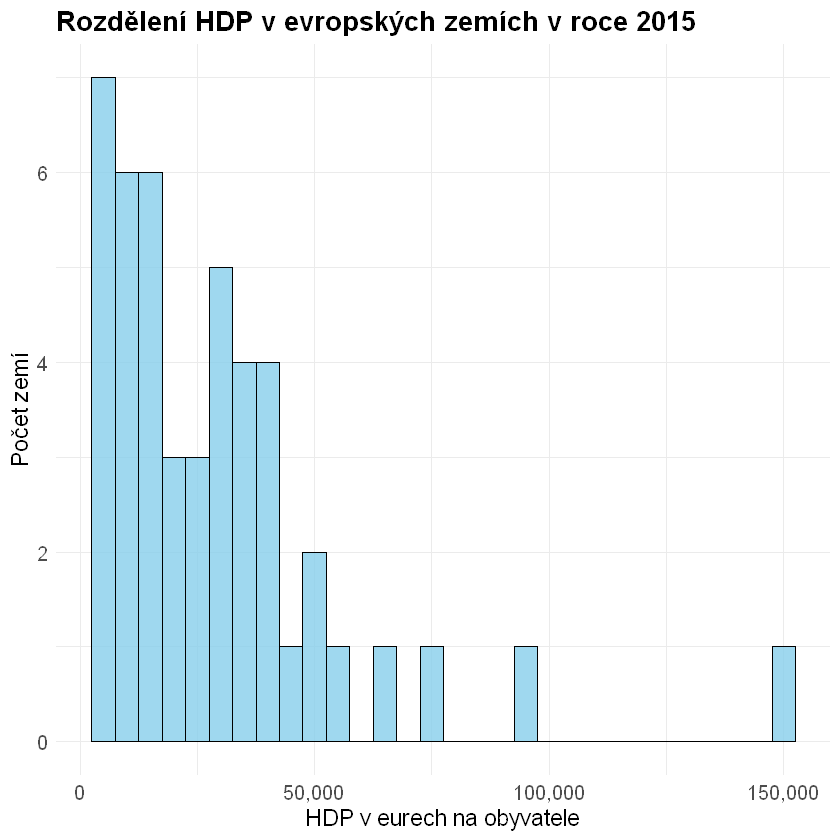

In [16]:
# Vytvoření histogramu s lepším nastavením
ggplot(data, aes(x = values)) +
  geom_histogram(binwidth = 5000, fill = "skyblue", color = "black", alpha = 0.8) +  # Alfa kanál pro průhlednost
  labs(title = "Rozdělení HDP v evropských zemích v roce 2015",
       x = "HDP v eurech na obyvatele",
       y = "Počet zemí") +
  scale_x_continuous(labels = scales::comma) +  # Přidání oddělovačů tisíců na osu x
  theme_minimal() +
  theme(plot.title = element_text(size = 16, face = "bold"),  # Velikost a styl titulku
        axis.text = element_text(size = 12),  # Velikost textu na osách
        axis.title = element_text(size = 14))  # Velikost popisků os

Tento histogram zobrazuje rozdělení hrubého domácího produktu (HDP) v evropských zemích v roce 2015. Na osu x je uvedeno HDP v eurech na obyvatele a na osu y počet zemí, které dosáhly dané úrovně HDP.

Graf ukazuje, že většina zemí má HDP mezi 10 000 a 50 000 eur na obyvatele. Existuje také menší počet zemí s HDP nad 50 000 eur na obyvatele, což může zahrnovat země s vyššími úrovněmi ekonomické prosperity.

Různé faktory mohou ovlivňovat HDP zemí. Některé z hlavních faktorů zahrnují:

* **Ekonomická politika**: Makroekonomická politika vlád, včetně monetární politiky a fiskální politiky, může mít vliv na HDP.

* **Obchodní politika**: Otevřenost země obchodu s ostatními zeměmi může ovlivnit HDP prostřednictvím exportu a importu zboží a služeb.

* **Technologický pokrok**: Inovace a technologický pokrok mohou zvyšovat produktivitu a stimulovat růst HDP.

* **Pracovní trh**: Zaměstnanost, úroveň mezd a pracovní podmínky mohou ovlivnit schopnost země generovat HDP.

* **Infrastruktura**: Kvalita infrastruktury, včetně dopravních sítí a telekomunikací, může mít vliv na efektivitu ekonomiky a tím i na HDP.

* **Politická stabilita**: Politická stabilita a právní rámec mohou ovlivnit investice a obchod, což může mít vliv na HDP.

## Úloha 2:
Pro zkoumané země můžeme zvolit následující čtyři údaje jako regresory pro analýzu vztahu k HDP:

1. **Průměrný věk obyvatelstva**: Tato numerická proměnná může poskytnout informace o demografické struktuře země a jejím vlivu na ekonomiku, jako je například pracovní síla a spotřeba.

2. **Hustota obyvatelstva**: Další numerická proměnná, která může ovlivnit HDP, je hustota obyvatelstva. Vyšší hustota obvykle znamená větší ekonomickou aktivitu a přístup k většímu trhu.

3. **Jazyk**: Tato kategoriální proměnná může být užitečná pro rozlišení mezi zeměmi na základě oficiálního nebo dominantního jazyka. Země se shodným jazykem mohou mít lepší obchodní vztahy a komunikaci, což může mít pozitivní vliv na ekonomiku a cestovní ruch.
4. **Měna**: Další kategoriální proměnná, která může být důležitá, je měna, kterou země používá. Země používající euro mohou mít výhodu v obchodě a stabilitě měny ve srovnání s zeměmi, které používají jiné měny.

Nyní bychom mohli použít regresní analýzu k určení vztahu mezi těmito proměnnými a HDP. Bylo by možné provést analýzu pomocí lineární regrese nebo jiných pokročilejších metod, abychom lépe porozuměli, jak tyto faktory ovlivňují ekonomický výkon zemí.

Chceme získat data o průměrném věku obyvatelstva z Eurostatu pro rok 2015 s pomocí identifikátoru MEDAGEPOP pro střední věk obyvatelstva. Vytvořím dotaz do databáze Eurostatu, abychom mohli získat požadovaná data.

### Průměrný věk obyvatelstva a Hustota obyvatelstva

In [80]:
# Dotaz na data o průměrném věku obyvatelstva za rok 2019
data_age <- get_eurostat("eq_pop04", filters = list(time="2015", indic_de = "MEDAGEPOP"))
# Zobrazení prvních řádků dat
head(data_age)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\Daria\AppData\Local\Temp\RtmpSAiTGL/eurostat/e29c8f94e4f187f131cfe7a86bdd1af6.rds

Table  eq_pop04  read from cache file:  C:\Users\Daria\AppData\Local\Temp\RtmpSAiTGL/eurostat/e29c8f94e4f187f131cfe7a86bdd1af6.rds



freq,indic_de,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,MEDAGEPOP,EU27_2020,2015-01-01,42.7
A,MEDAGEPOP,EA20,2015-01-01,NA
A,MEDAGEPOP,EA19,2015-01-01,43.3
A,MEDAGEPOP,BE,2015-01-01,41.4
A,MEDAGEPOP,BG,2015-01-01,43.4
A,MEDAGEPOP,CZ,2015-01-01,41.1


In [81]:
# Drop unnecessary columns
data_age <- subset(data_age, select = c("geo", "values"))
data_age <- label_eurostat(data_age)
head(data_age)

geo,values
<chr>,<dbl>
European Union - 27 countries (from 2020),42.7
Euro area – 20 countries (from 2023),NA
Euro area - 19 countries (2015-2022),43.3
Belgium,41.4
Bulgaria,43.4
Czechia,41.1


Pro získání dat o hustotě obyvatelstva z Eurostatu pro rok 2015 s pomocí identifikátoru tps00003 pro hustotu obyvatelstva vytvořím dotaz do databáze Eurostatu.

In [82]:
data_density <- get_eurostat("tps00003", filters = list(time="2015"))

# Zobrazení prvních řádků dat
head(data_density)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\Daria\AppData\Local\Temp\RtmpSAiTGL/eurostat/e9e32885d2653b84fcfdc1d4349019e9.rds

Table  tps00003  read from cache file:  C:\Users\Daria\AppData\Local\Temp\RtmpSAiTGL/eurostat/e9e32885d2653b84fcfdc1d4349019e9.rds



freq,unit,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,PER_KM2,EU27_2020,2015-01-01,108.1
A,PER_KM2,EA20,2015-01-01,NA
A,PER_KM2,EA19,2015-01-01,NA
A,PER_KM2,BE,2015-01-01,371.8
A,PER_KM2,BG,2015-01-01,66.2
A,PER_KM2,CZ,2015-01-01,136.6


In [83]:
# Identifikace chybějících hodnot
missing_values <- is.na(data_age)

# Zobrazení řádků s chybějícími hodnotami
rows_with_missing <- data_age[apply(missing_values, 1, any), ]
print(rows_with_missing)


# A tibble: 7 × 2
  geo                                  values
  <chr>                                 <dbl>
1 Euro area – 20 countries (from 2023)     NA
2 Metropolitan France                      NA
3 Norway                                   NA
4 Kosovo*                                  NA
5 Andorra                                  NA
6 Russia                                   NA
7 San Marino                               NA


In [84]:
# Drop unnecessary columns
data_density <- subset(data_density, select = c("geo", "values"))
data_density <- label_eurostat(data_density)
head(data_density)

geo,values
<chr>,<dbl>
European Union - 27 countries (from 2020),108.1
Euro area – 20 countries (from 2023),NA
Euro area - 19 countries (2015-2022),NA
Belgium,371.8
Bulgaria,66.2
Czechia,136.6


In [85]:
# Identifikace chybějících hodnot
missing_values <- is.na(data_density)

# Zobrazení řádků s chybějícími hodnotami
rows_with_missing <- data_density[apply(missing_values, 1, any), ]
print(rows_with_missing)


# A tibble: 3 × 2
  geo                                   values
  <chr>                                  <dbl>
1 Euro area – 20 countries (from 2023)      NA
2 Euro area - 19 countries  (2015-2022)     NA
3 Serbia                                    NA


In [86]:
summary(data_age$values)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  30.50   38.67   41.25   40.25   42.73   45.90       7 

In [87]:
summary(data_density$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    3.3    68.5   102.4   158.3   136.6  1408.4       3 

Warning message:
"Removed 7 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 3 rows containing non-finite outside the scale range (`stat_bin()`)."


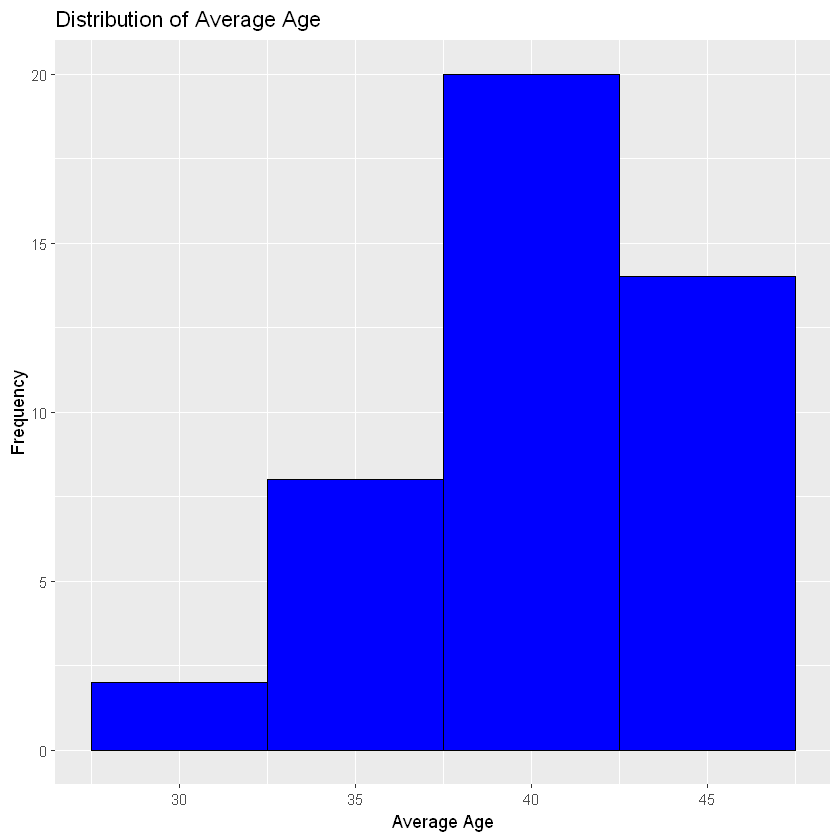

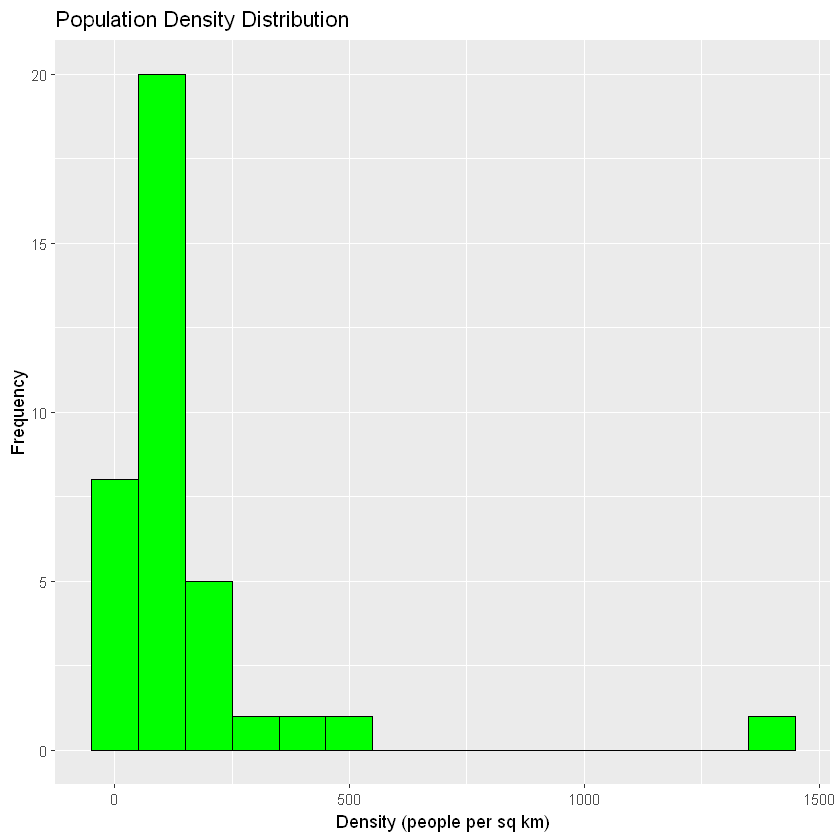

In [88]:
# Age
ggplot(data_age, aes(x=values)) + 
  geom_histogram(binwidth=5, fill="blue", color="black") +
  ggtitle("Distribution of Average Age") +
  xlab("Average Age") + 
  ylab("Frequency")

# density
ggplot(data_density, aes(x=values)) + 
  geom_histogram(binwidth=100, fill="green", color="black") +  
  ggtitle("Population Density Distribution") +
  xlab("Density (people per sq km)") + 
  ylab("Frequency")



Na histogramu distribuce průměrného věku vidíme, že největší počet zemí má průměrný věk obyvatelstva kolem 40 let, zatímco distribuce hustoty obyvatelstva ukazuje, že většina zemí má nízkou hustotu obyvatelstva, s několika zeměmi výrazně odlišnými s velmi vysokou hustotou.

In [89]:
# rename
data_age_renamed <- data_age %>% rename(age = values)
data_density_renamed <- data_density %>% rename(density = values)

# join
combined_data <- left_join(data_age_renamed, data_density_renamed, by = "geo")

# corr
correlation_result <- cor(combined_data$age, combined_data$density, use = "complete.obs")
print(correlation_result)  



[1] 0.07637682


Korelace ve výši 0,07637682 ukazuje velmi slabou pozitivní souvislost mezi průměrným věkem obyvatelstva a hustotou obyvatelstva. To naznačuje, že vztah mezi těmito dvěma proměnnými je téměř zanedbatelný a pravděpodobně by nebyl významným faktorem ve většině ekonomických modelů.

In [90]:
data_hdp_renamed <- data %>% rename(hdp = values)

In [91]:
data1 <- merge(data_hdp_renamed, data_age_renamed, by = "geo")
data2 <- merge(data1, data_density_renamed, by = "geo")

In [92]:
head(data2)

,geo,hdp,age,density
,<chr>,<dbl>,<dbl>,<dbl>
1,Albania,3560,34.7,100.1
2,Austria,39890,43.0,104.9
3,Belgium,36960,41.4,371.8
4,Bulgaria,6380,43.4,66.2
5,Croatia,10810,42.8,74.4
6,Cyprus,21170,37.0,92.0


### Jazyk a Mena

In [93]:
# Loading data from a CSV file
world_data <- read.csv("world-data-2023.csv", header = TRUE, sep = ",", quote = "\"", dec = ".", fill = TRUE, na.strings = c("", "NA"))

head(world_data)


,Country,Density..P.Km2.,Abbreviation,Agricultural.Land....,Land.Area.Km2.,Armed.Forces.size,Birth.Rate,Calling.Code,Capital.Major.City,Co2.Emissions,⋯,Out.of.pocket.health.expenditure,Physicians.per.thousand,Population,Population..Labor.force.participation....,Tax.revenue....,Total.tax.rate,Unemployment.rate,Urban_population,Latitude,Longitude
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93,Kabul,"8,672",⋯,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.93911,67.709953
2,Albania,105,AL,43.10%,"28,748","9,000",11.78,355,Tirana,"4,536",⋯,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.15333,20.168331
3,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213,Algiers,"150,006",⋯,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.03389,1.659626
4,Andorra,164,AD,40.00%,468,NA,7.20,376,Andorra la Vella,469,⋯,36.40%,3.33,"77,142",NA,NA,NA,NA,"67,873",42.50628,1.521801
5,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244,Luanda,"34,693",⋯,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.20269,17.873887
6,Antigua and Barbuda,223,AG,20.50%,443,0,15.33,1,"St. John's, Saint John",557,⋯,24.30%,2.76,"97,118",NA,16.50%,43.00%,NA,"23,800",17.06082,-61.796428


In [94]:
colnames(world_data)

[1] "Country"                                  
 [2] "Density..P.Km2."                          
 [3] "Abbreviation"                             
 [4] "Agricultural.Land...."                    
 [5] "Land.Area.Km2."                           
 [6] "Armed.Forces.size"                        
 [7] "Birth.Rate"                               
 [8] "Calling.Code"                             
 [9] "Capital.Major.City"                       
[10] "Co2.Emissions"                            
[11] "CPI"                                      
[12] "CPI.Change...."                           
[13] "Currency.Code"                            
[14] "Fertility.Rate"                           
[15] "Forested.Area...."                        
[16] "Gasoline.Price"                           
[17] "GDP"                                      
[18] "Gross.primary.education.enrollment...."   
[19] "Gross.tertiary.education.enrollment...."  
[20] "Infant.mortality"                         
[21] "Largest.city"                             
[22] "Life.expectancy"                          
[23] "Maternal.mortality.ratio"                 
[24] "Minimum.wage"                             
[25] "Official.language"                        
[26] "Out.of.pocket.health.expenditure"         
[27] "Physicians.per.thousand"                  
[28] "Population"                               
[29] "Population..Labor.force.participation...."
[30] "Tax.revenue...."                          
[31] "Total.tax.rate"                           
[32] "Unemployment.rate"                        
[33] "Urban_population"                         
[34] "Latitude"                                 
[35] "Longitude"

In [95]:
data_language <- world_data %>% select(Country, Official.language) 

In [96]:
data_language_renamed <- data_language %>% rename(geo = Country, language = Official.language)

In [97]:
data_currency <- world_data %>% select(Country, Currency.Code) 

In [98]:
data_currency_renamed <- data_currency %>% rename(geo = Country, currency = Currency.Code)

In [99]:
summary(data_language_renamed)

     geo              language        
 Length:195         Length:195        
 Class :character   Class :character  
 Mode  :character   Mode  :character  

In [100]:
summary(data_currency_renamed)

     geo              currency        
 Length:195         Length:195        
 Class :character   Class :character  
 Mode  :character   Mode  :character  

In [101]:
data3 <- merge(data_hdp_renamed, data_language_renamed, by = "geo")
data4 <- merge(data3, data_currency_renamed, by = "geo")

In [102]:
head(data4)

,geo,hdp,language,currency
,<chr>,<dbl>,<chr>,<chr>
1,Albania,3560,Albanian,ALL
2,Austria,39890,German,EUR
3,Belgium,36960,French,EUR
4,Bosnia and Herzegovina,7240,Bosnian,BAM
5,Bulgaria,6380,Bulgarian,BGN
6,Croatia,10810,Croatian,HRK


In [103]:
data4 <- data4 %>%
  mutate(language = as.factor(language),
         currency = as.factor(currency))


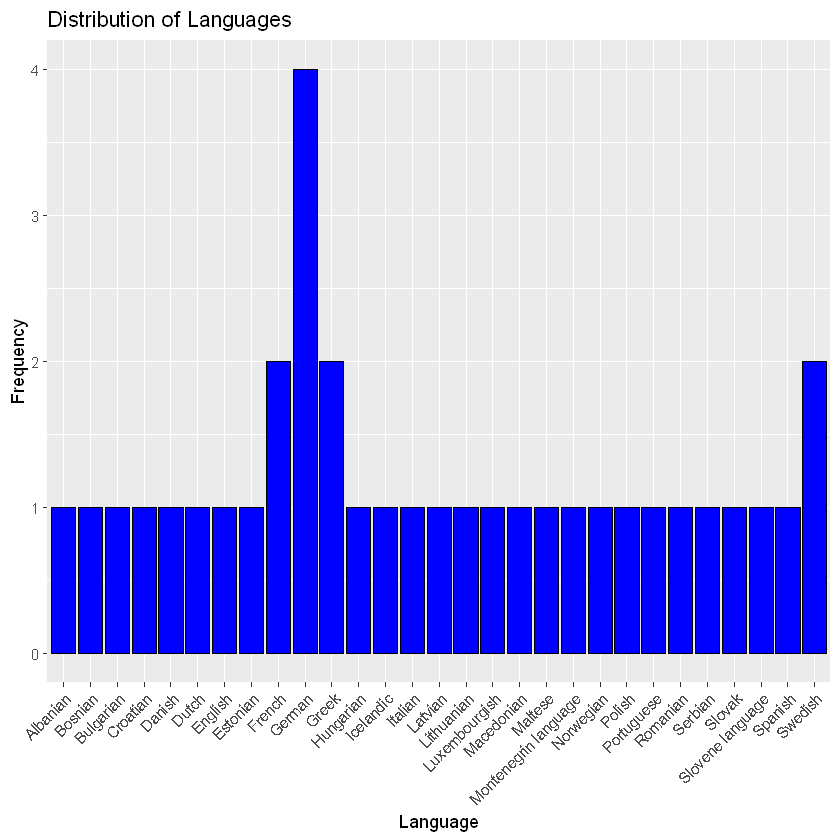

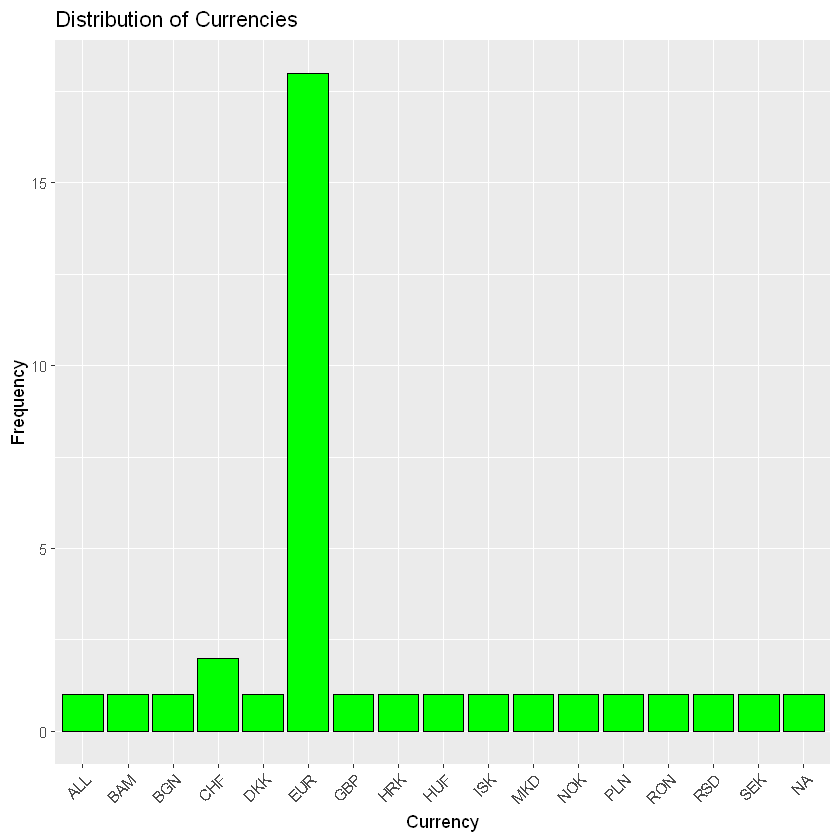

In [110]:
library(ggplot2)

# language
ggplot(data4, aes(x=language)) + 
  geom_bar(fill="blue", color="black") +
  ggtitle("Distribution of Languages") +
  xlab("Language") + 
  ylab("Frequency") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  

# currency
ggplot(data4, aes(x=currency)) + 
  geom_bar(fill="green", color="black") +
  ggtitle("Distribution of Currencies") +
  xlab("Currency") + 
  ylab("Frequency") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 


In [111]:
table_language_currency <- table(data4$language, data4$currency)

# Fisher's test
fisher_test <- fisher.test(table_language_currency)
print(fisher_test)


	Fisher's Exact Test for Count Data

data:  table_language_currency
p-value = 1.375e-11
alternative hypothesis: two.sided



Výsledky Fisherova přesného testu s p-hodnotou 1.375e-11 ukazují, že mezi jazykem a měnou existuje statisticky významná závislost.

## Úloha 3:

### Age and Density

In [106]:
model <- lm(hdp ~ age + density, data = data2)
summary(model)


Call:
lm(formula = hdp ~ age + density, data = data2)

Residuals:
   Min     1Q Median     3Q    Max 
-25928 -18463  -8590   7645 114444 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -17192.40   65230.19  -0.264    0.794
age           1120.52    1599.63   0.700    0.489
density         13.14      20.88   0.630    0.533

Residual standard error: 29100 on 33 degrees of freedom
  (4 пропущенных наблюдений удалены)
Multiple R-squared:  0.02827,	Adjusted R-squared:  -0.03063 
F-statistic:  0.48 on 2 and 33 DF,  p-value: 0.623


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range (`geom_point()`)."


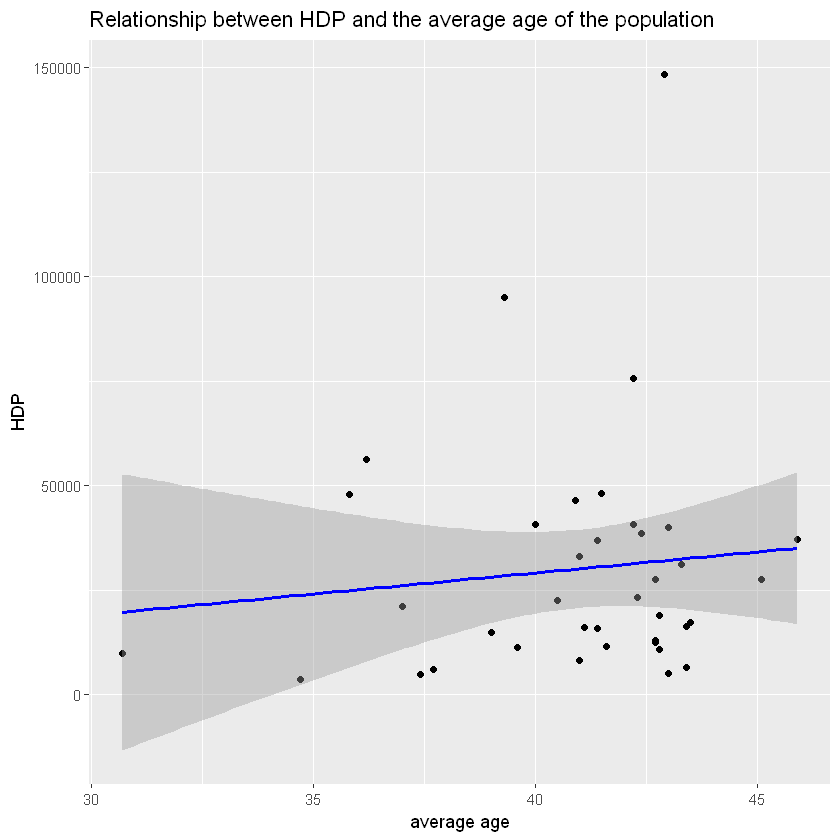

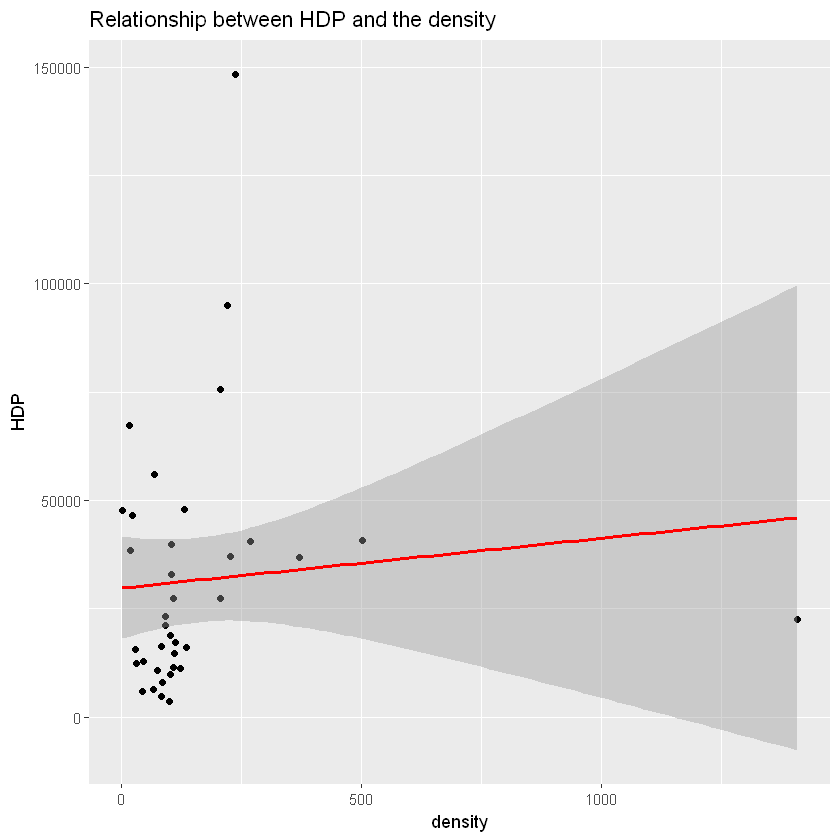

In [107]:
# age
ggplot(data2, aes(x = age, y = hdp)) +
  geom_point() +
  geom_smooth(method = "lm", col = "blue") +
  labs(title = "Relationship between HDP and the average age of the population", x = "average age", y = "HDP")

#density
ggplot(data2, aes(x = density, y = hdp)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  labs(title = "Relationship between HDP and the density", x = "density", y = "HDP")


Grafy ukazují, že i když existuje pozitivní trend mezi průměrným věkem obyvatelstva a HDP, a negativní trend mezi hustotou obyvatelstva a HDP, oba tyto vztahy nejsou statisticky významné, což potvrzují analýzy regresních modelů.


### Language and Currency

In [108]:
model <- lm(hdp ~ language + currency, data = data4)
summary(model)


Call:
lm(formula = hdp ~ language + currency, data = data4)

Residuals:
         1          2          3          4          5          6          7 
 1.595e-11  1.420e+03  1.970e+03  6.052e-14  2.199e-12  5.082e-13  2.435e+03 
         8          9         10         11         12         13         14 
 3.464e-12 -4.068e-12  3.191e-11 -1.970e+03 -1.420e+03 -2.435e+03  2.524e-13 
        15         16         17         18         19         20         21 
 6.503e-13 -1.169e-12 -1.737e-12  3.646e+04  5.934e-13 -1.112e-12 -1.271e-11 
        22         24         25         26         27         28         29 
 3.208e-12  1.332e-12  5.027e-12  6.391e-12 -1.339e-12 -1.339e-12 -1.339e-12 
        30         31         32         33         34         35 
-2.703e-12  2.753e-12  2.499e-14 -2.635e-11 -3.646e+04 -4.866e-13 

Coefficients: (13 not defined because of singularities)
                             Estimate Std. Error t value Pr(>|t|)
(Intercept)                      3560      258

Model lineární regrese ukazuje, že ani jazyk ani měna nemají statisticky významný vliv na HDP, což dokládají vysoké p-hodnoty a nízký upravený R-kvadrát, naznačující možné přeučení modelu.

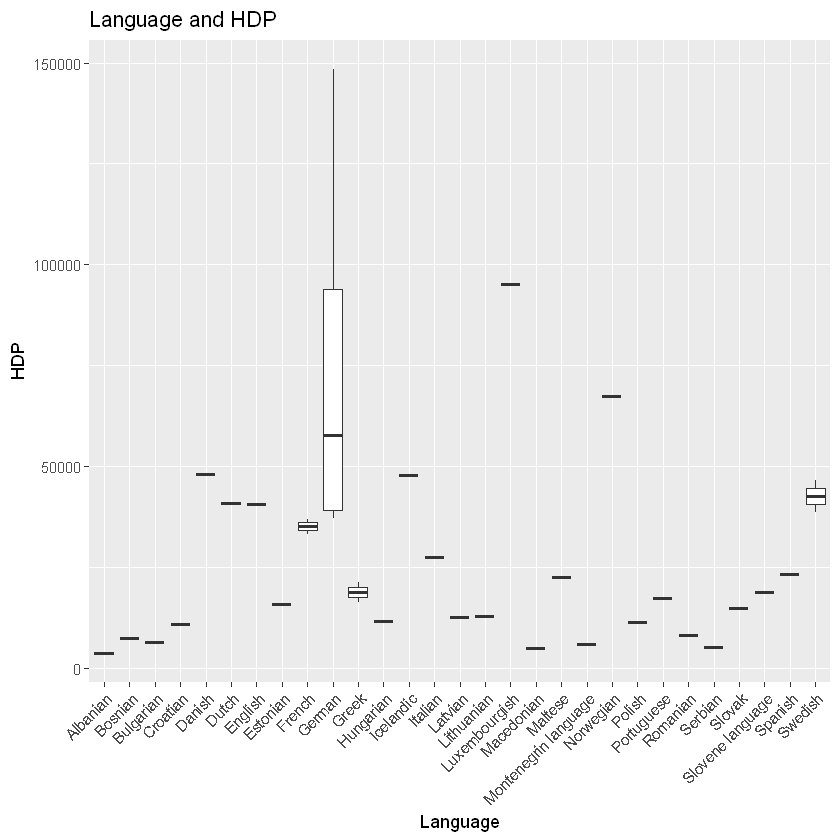

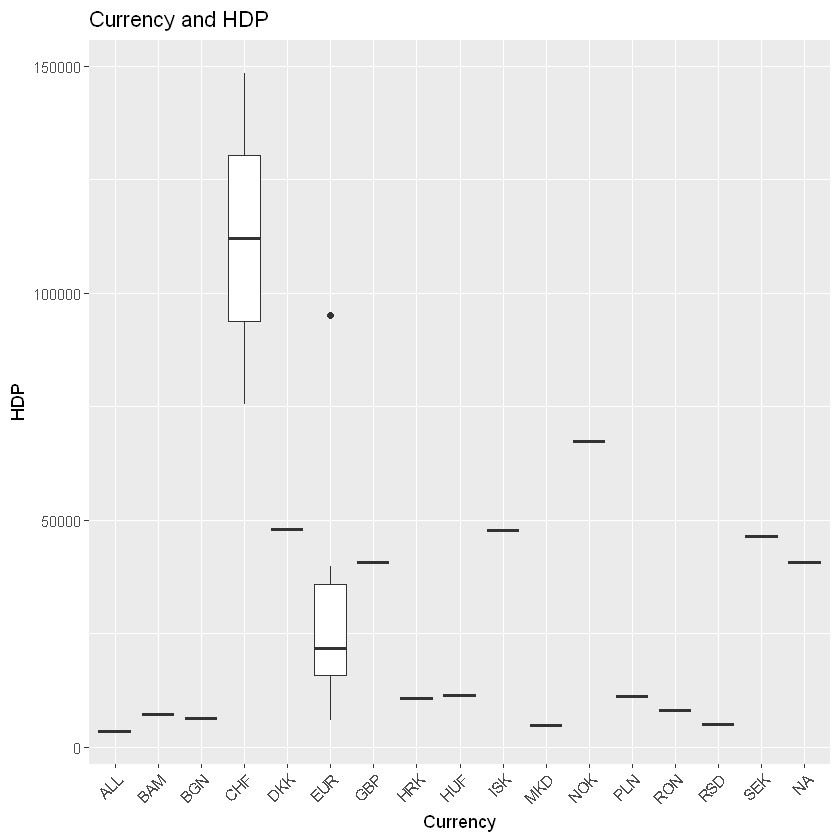

In [109]:
ggplot(data4, aes(x = language, y = hdp)) +
  geom_boxplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Language and HDP", x = "Language", y = "HDP")

ggplot(data4, aes(x = currency, y = hdp)) +
  geom_boxplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Currency and HDP", x = "Currency", y = "HDP")

Grafy ukazují, že existují výrazné rozdíly v HDP v závislosti na používané měně a jazyce, přičemž některé měny jako CHF a GBP a jazykové skupiny jako německá a francouzská mají tendenci být spojeny s vyšším HDP.